Getting credentials...
Discovering files for cycles 14-16...
Found 331 files to process
Download size: ~8.7 GB, Final size: ~1.6 GB
Starting download and extraction...

[1/331] Cycle 014, Pass 014

[2/331] Cycle 014, Pass 014

[3/331] Cycle 014, Pass 014

[4/331] Cycle 014, Pass 014

[5/331] Cycle 014, Pass 014

[6/331] Cycle 014, Pass 014

[7/331] Cycle 014, Pass 014

[8/331] Cycle 014, Pass 014

[9/331] Cycle 014, Pass 014

[10/331] Cycle 014, Pass 014

[11/331] Cycle 014, Pass 014

[12/331] Cycle 014, Pass 014

[13/331] Cycle 014, Pass 014

[14/331] Cycle 014, Pass 014

[15/331] Cycle 014, Pass 014

[16/331] Cycle 014, Pass 014

[17/331] Cycle 014, Pass 014

[18/331] Cycle 014, Pass 014

[19/331] Cycle 014, Pass 014

[20/331] Cycle 014, Pass 014

[21/331] Cycle 014, Pass 014

[22/331] Cycle 014, Pass 014

[23/331] Cycle 014, Pass 014

[24/331] Cycle 014, Pass 014

[25/331] Cycle 014, Pass 014

[26/331] Cycle 014, Pass 014

[27/331] Cycle 014, Pass 014

[28/331] Cycle 014, Pass 014



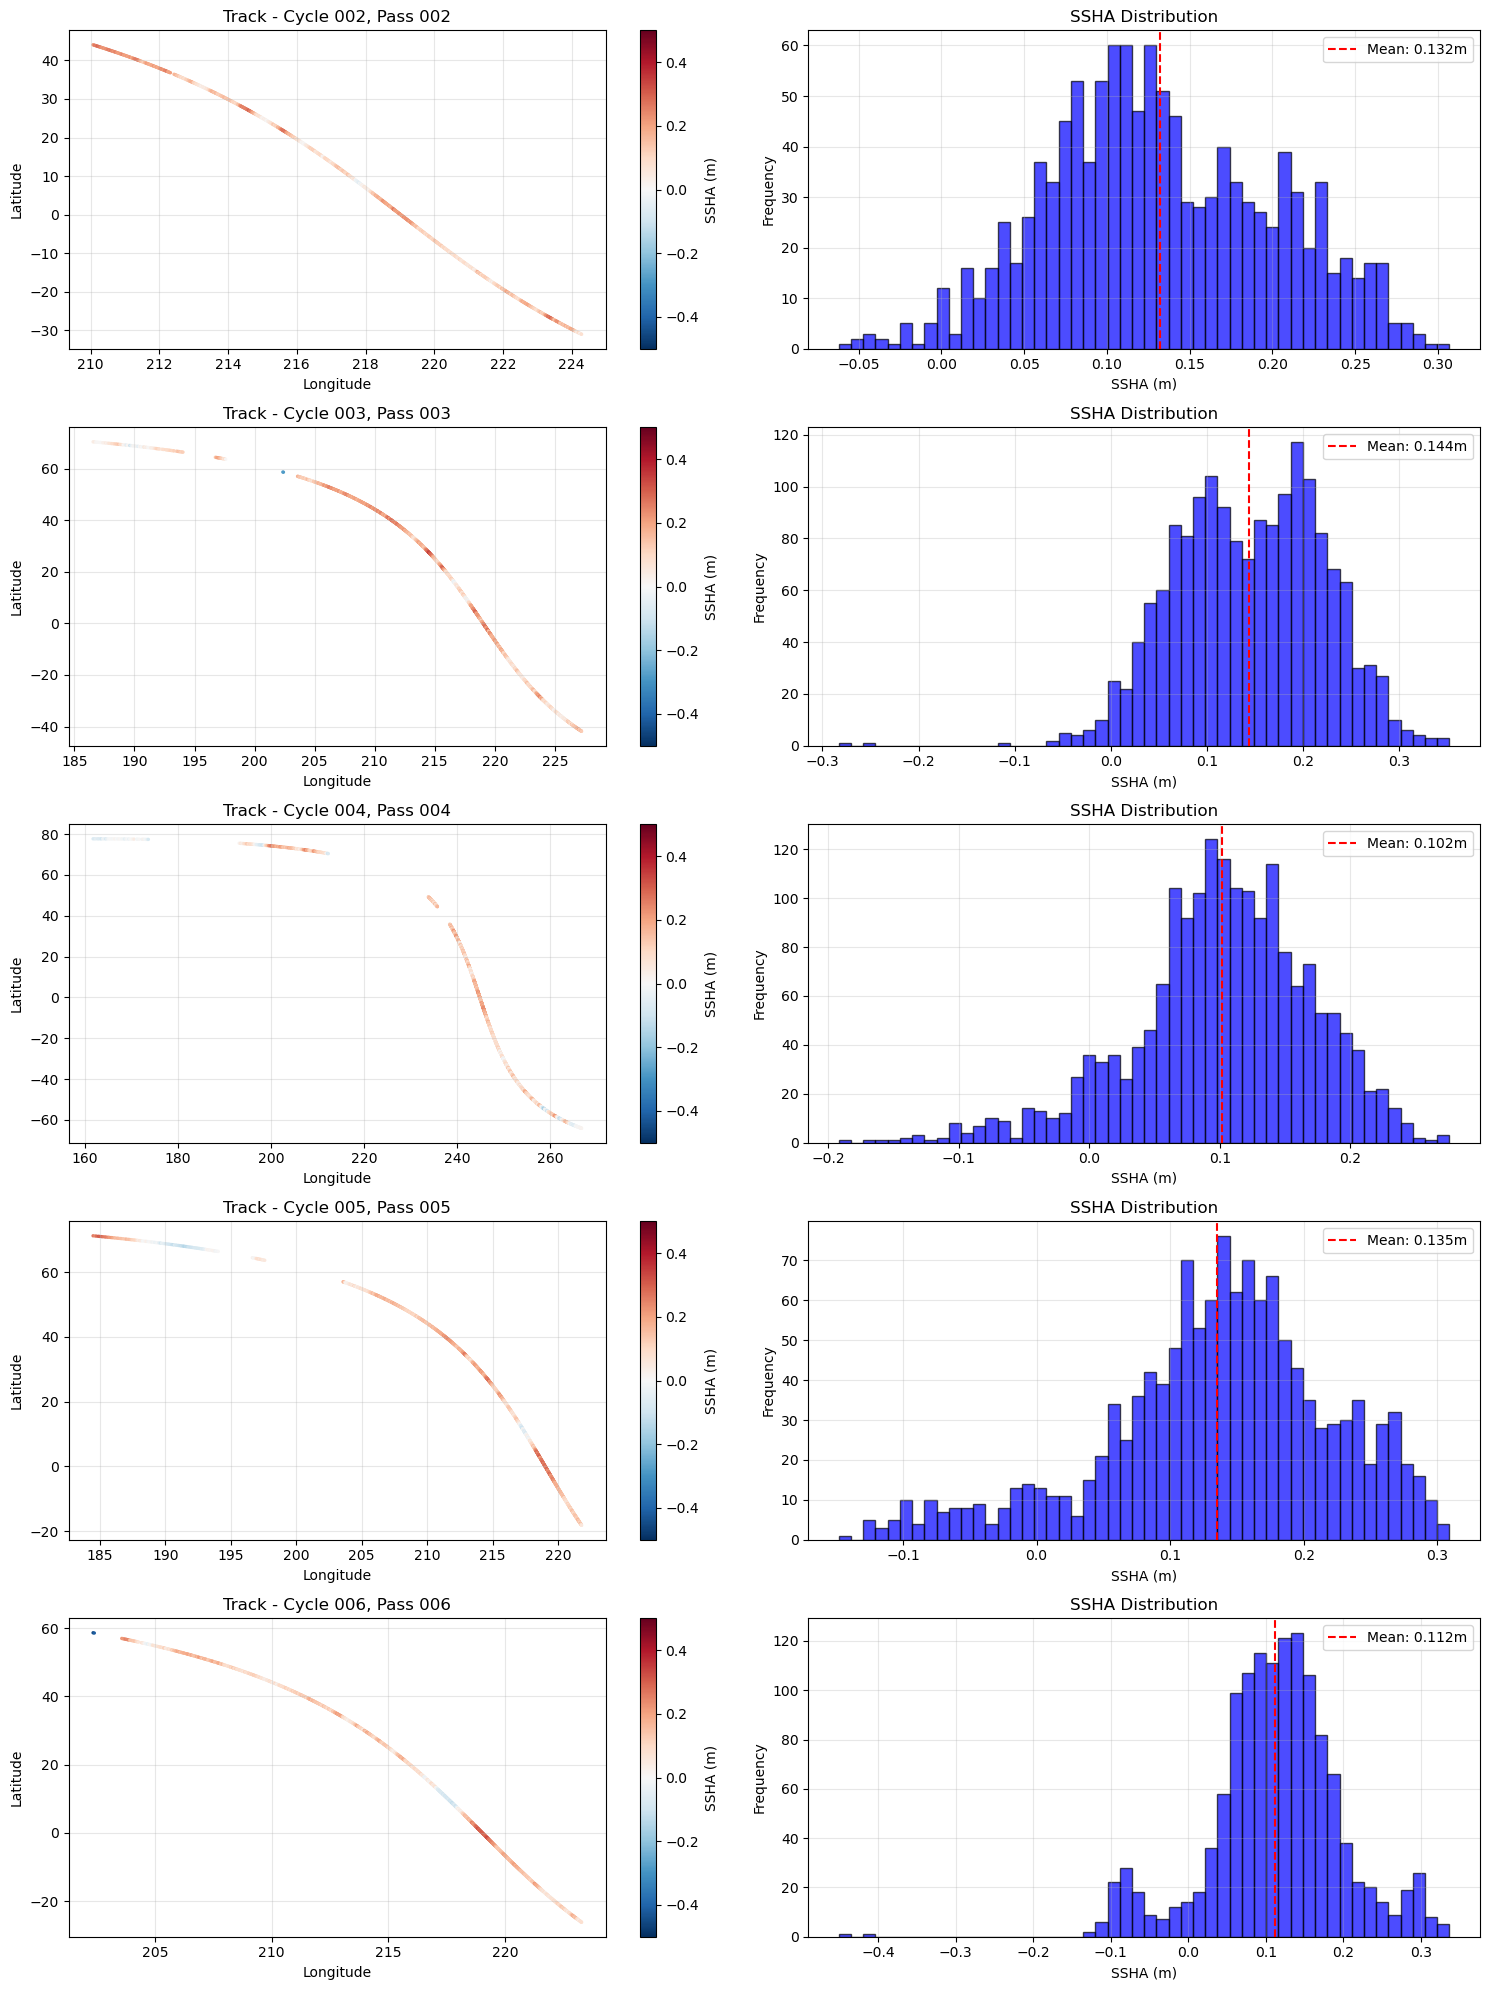

Extracting center swath data...
Total SSHA points: 59716

Data ready for analysis!
Available variables:
- datasets: Dictionary of xarray datasets
- coverage_df: Pandas DataFrame with coverage statistics
- center_data: Pandas DataFrame with center swath data


In [6]:
import os
import netrc
import threddsclient
import requests as rq
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
TARGET_PASSES = ["007", "009", "011", "013", "022", "024", "035", "037", "039",
"041", "048", "050", "052", "063", "067", "069", "076", "078", "080", "091", 
"095", "097", "104", "106", "108", "119", "123", "125", "132", "136", "147", 
"151", "160", "164", "175", "179", "188", "190", "192", "203", "205", "207", 
"216", "218", "220", "231", "233", "235", "244", "246", "248", "259", "261", 
"263", "272", "274", "276", "285", "287", "289", "291", "300", "302", "313", 
"315", "317", "319", "328", "330", "341", "345", "347", "354", "356", "358", 
"369", "373", "375", "382", "384", "386", "397", "401", "403", "410", "425", 
"429", "438", "442", "453", "457", "466", "468", "470", "481", "485", "494", 
"496", "498", "509", "511", "513", "522", "524", "526", "537", "539", "541", 
"550", "552", "554", "563", "565", "567", "569", "578", "580", "582"]

CYCLE_START = 14
CYCLE_END = 16
OUTPUT_DIR = "swot_ssha_data"

def get_credentials():
    try:
        netrc_info = netrc.netrc()
        for host in ['tds-odatis.aviso.altimetry.fr', 'ftp-access.aviso.altimetry.fr']:
            try:
                auth_info = netrc_info.authenticators(host)
                if auth_info:
                    return auth_info[0], auth_info[2]
            except:
                continue
    except:
        pass
    
    from getpass import getpass
    username = input("Username: ")
    password = getpass("Password: ")
    return username, password

def get_file_urls_for_cycle(cycle_num):
    cycle_str = f"{cycle_num:03d}"
    catalog_url = f"https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Basic/cycle_{cycle_str}/catalog.html"
    
    try:
        files = list(threddsclient.crawl(catalog_url, depth=1))
        basic_files = [f for f in files if f'SWOT_L3_LR_SSH_Basic_{cycle_str}_' in f.name]
        
        selected_files = []
        for target_pass in TARGET_PASSES:
            matching = [f for f in basic_files if f"_{cycle_str}_{target_pass}_" in f.name]
            selected_files.extend(matching)
        
        base_url = f"https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Basic/cycle_{cycle_str}/"
        
        file_info = []
        for f in selected_files:
            file_info.append({
                'name': f.name,
                'url': base_url + f.name,
                'cycle': cycle_str,
                'pass': f.name.split('_')[5] if len(f.name.split('_')) > 5 else 'unknown'
            })
        
        return file_info
        
    except Exception as e:
        print(f"Error getting catalog for cycle {cycle_str}: {e}")
        return []

def download_and_extract_ssha(file_info, username, password):
    cycle_dir = Path(OUTPUT_DIR) / f"cycle_{file_info['cycle']}"
    cycle_dir.mkdir(parents=True, exist_ok=True)
    
    full_file = cycle_dir / file_info['name']
    ssha_file = cycle_dir / file_info['name'].replace('.nc', '_ssha_only.nc')
    
    # Check if SSHA file already exists
    if ssha_file.exists():
        try:
            ds = xr.open_dataset(ssha_file)
            if 'ssha_filtered' in ds and ds.ssha_filtered.size > 0:
                ds.close()
                return str(ssha_file)
            ds.close()
        except:
            pass
    
    # Download full file if needed
    if not full_file.exists():
        try:
            session = rq.Session()
            session.auth = (username, password)
            
            response = session.get(file_info['url'], timeout=600, stream=True)
            
            if response.status_code == 200:
                total_size = int(response.headers.get('content-length', 0))
                
                with open(full_file, 'wb') as f:
                    if total_size > 0:
                        with tqdm(total=total_size, unit='B', unit_scale=True, desc=f"Downloading {file_info['name']}") as pbar:
                            for chunk in response.iter_content(chunk_size=8192):
                                if chunk:
                                    f.write(chunk)
                                    pbar.update(len(chunk))
                    else:
                        for chunk in response.iter_content(chunk_size=8192):
                            if chunk:
                                f.write(chunk)
            else:
                print(f"Download failed: HTTP {response.status_code}")
                return None
                
        except Exception as e:
            print(f"Download error: {e}")
            return None
    
    # Extract SSHA data only
    try:
        with xr.open_dataset(full_file) as ds:
            ssha_ds = xr.Dataset({
                'ssha_filtered': ds.ssha_filtered,
                'latitude': ds.latitude,
                'longitude': ds.longitude,
                'time': ds.time
            })
            
            ssha_ds.attrs.update({
                'cycle': file_info['cycle'],
                'pass': file_info['pass'],
                'original_file': file_info['name']
            })
            
            encoding = {
                'ssha_filtered': {'zlib': True, 'complevel': 5},
                'latitude': {'zlib': True, 'complevel': 5},
                'longitude': {'zlib': True, 'complevel': 5}
            }
            
            ssha_ds.to_netcdf(ssha_file, encoding=encoding)
        
        # Remove full file to save space
        if full_file.exists():
            os.remove(full_file)
        
        return str(ssha_file)
        
    except Exception as e:
        print(f"Extraction error: {e}")
        return str(full_file) if full_file.exists() else None

def load_ssha_data(data_dir=OUTPUT_DIR):
    files = list(Path(data_dir).glob("**/*_ssha_only.nc"))
    
    if not files:
        print(f"No SSHA files found in {data_dir}")
        return {}
    
    datasets = {}
    for file_path in files:
        try:
            ds = xr.open_dataset(file_path)
            cycle = ds.attrs.get('cycle', 'unknown')
            pass_num = ds.attrs.get('pass', 'unknown')
            key = f"cycle_{cycle}_pass_{pass_num}"
            datasets[key] = ds
        except Exception as e:
            print(f"Failed to load {file_path.name}: {e}")
    
    return datasets

def analyze_coverage(datasets):
    coverage_data = []
    
    for key, ds in datasets.items():
        total_points = ds.ssha_filtered.size
        valid_points = np.sum(~np.isnan(ds.ssha_filtered.values))
        coverage_pct = valid_points / total_points * 100
        
        ssha_values = ds.ssha_filtered.values
        valid_ssha = ssha_values[~np.isnan(ssha_values)]
        
        coverage_data.append({
            'dataset': key,
            'cycle': ds.attrs.get('cycle', 'unknown'),
            'pass': ds.attrs.get('pass', 'unknown'),
            'coverage_percent': coverage_pct,
            'ssha_mean': np.mean(valid_ssha) if len(valid_ssha) > 0 else np.nan,
            'ssha_std': np.std(valid_ssha) if len(valid_ssha) > 0 else np.nan,
            'lat_min': float(ds.latitude.min()),
            'lat_max': float(ds.latitude.max()),
            'lon_min': float(ds.longitude.min()),
            'lon_max': float(ds.longitude.max())
        })
    
    return pd.DataFrame(coverage_data)

def plot_overview(datasets):
    if not datasets:
        print("No datasets to plot")
        return None
        
    dataset_keys = list(datasets.keys())[:5]  # Plot first 5
    
    fig, axes = plt.subplots(len(dataset_keys), 2, figsize=(15, 4*len(dataset_keys)))
    if len(dataset_keys) == 1:
        axes = axes.reshape(1, -1)
    
    for i, key in enumerate(dataset_keys):
        ds = datasets[key]
        cycle = ds.attrs.get('cycle', 'unknown')
        pass_num = ds.attrs.get('pass', 'unknown')
        
        # Track plot
        ax1 = axes[i, 0]
        center_pixel = ds.sizes['num_pixels'] // 2
        
        lats = ds.latitude.isel(num_pixels=center_pixel).values
        lons = ds.longitude.isel(num_pixels=center_pixel).values
        ssha = ds.ssha_filtered.isel(num_pixels=center_pixel).values
        
        valid_mask = ~np.isnan(ssha)
        if valid_mask.any():
            scatter = ax1.scatter(lons[valid_mask], lats[valid_mask], 
                                c=ssha[valid_mask], s=2, cmap='RdBu_r', 
                                vmin=-0.5, vmax=0.5)
            plt.colorbar(scatter, ax=ax1, label='SSHA (m)')
        
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_title(f'Track - Cycle {cycle}, Pass {pass_num}')
        ax1.grid(True, alpha=0.3)
        
        # SSHA histogram
        ax2 = axes[i, 1]
        valid_ssha = ssha[valid_mask]
        if len(valid_ssha) > 0:
            ax2.hist(valid_ssha, bins=50, alpha=0.7, color='blue', edgecolor='black')
            ax2.axvline(np.mean(valid_ssha), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(valid_ssha):.3f}m')
            ax2.legend()
        
        ax2.set_xlabel('SSHA (m)')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'SSHA Distribution')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def extract_center_data(datasets):
    combined_data = []
    
    for key, ds in datasets.items():
        cycle = ds.attrs.get('cycle', 'unknown')
        pass_num = ds.attrs.get('pass', 'unknown')
        
        center_pixel = ds.sizes['num_pixels'] // 2
        
        data = {
            'cycle': cycle,
            'pass': pass_num,
            'time': pd.to_datetime(ds.time.values),
            'latitude': ds.latitude.isel(num_pixels=center_pixel).values,
            'longitude': ds.longitude.isel(num_pixels=center_pixel).values,
            'ssha_filtered': ds.ssha_filtered.isel(num_pixels=center_pixel).values
        }
        
        df = pd.DataFrame(data)
        df = df.dropna(subset=['ssha_filtered'])
        combined_data.append(df)
    
    if combined_data:
        return pd.concat(combined_data, ignore_index=True)
    else:
        return pd.DataFrame()

# Main execution
print("Getting credentials...")
username, password = get_credentials()

print(f"Discovering files for cycles {CYCLE_START}-{CYCLE_END}...")
all_files = []
for cycle in range(CYCLE_START, CYCLE_END + 1):
    cycle_files = get_file_urls_for_cycle(cycle)
    all_files.extend(cycle_files)

if not all_files:
    print("No files found!")
else:
    print(f"Found {len(all_files)} files to process")
    est_size_gb = len(all_files) * 27 / 1024
    final_size_gb = len(all_files) * 5 / 1024
    print(f"Download size: ~{est_size_gb:.1f} GB, Final size: ~{final_size_gb:.1f} GB")
    
    print("Starting download and extraction...")
    downloaded_files = []
    
    for i, file_info in enumerate(all_files, 1):
        print(f"\n[{i}/{len(all_files)}] Cycle {file_info['cycle']}, Pass {file_info['pass']}")
        result = download_and_extract_ssha(file_info, username, password)
        if result:
            downloaded_files.append(result)
    
    print(f"\nProcessing complete! Downloaded {len(downloaded_files)} files")
    
    if downloaded_files:
        print("Loading SSHA data...")
        datasets = load_ssha_data()
        
        if datasets:
            print(f"Loaded {len(datasets)} datasets")
            
            print("Analyzing coverage...")
            coverage_df = analyze_coverage(datasets)
            print("\nCoverage Summary:")
            print(coverage_df[['cycle', 'pass', 'coverage_percent', 'ssha_mean', 'ssha_std']].round(3))
            
            print("Creating plots...")
            fig = plot_overview(datasets)
            if fig:
                plt.show()
            
            print("Extracting center swath data...")
            center_data = extract_center_data(datasets)
            print(f"Total SSHA points: {len(center_data)}")
            
            print("\nData ready for analysis!")
            print("Available variables:")
            print("- datasets: Dictionary of xarray datasets")
            print("- coverage_df: Pandas DataFrame with coverage statistics")
            print("- center_data: Pandas DataFrame with center swath data")
        else:
            print("No datasets could be loaded")
    else:
        print("No files were successfully downloaded")